In [1]:
import cv2
from matplotlib import pyplot as plt
from skimage import feature as ft
%matplotlib inline

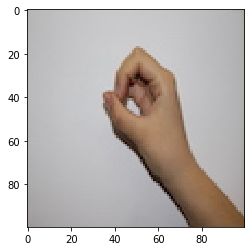

In [2]:
img = cv2.imread(r"C:\Users\Bye_l\Desktop\Dataset\0\IMG_1118.JPG")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [3]:
import glob
file_path = glob.glob(r"C:\Users\Bye_l\Desktop\Dataset\*\*.JPG")
file_path[0], file_path[-1]

('C:\\Users\\Bye_l\\Desktop\\Dataset\\0\\IMG_1118.JPG',
 'C:\\Users\\Bye_l\\Desktop\\Dataset\\9\\IMG_5990.JPG')

In [4]:
import random
import tqdm
import numpy as np

In [5]:
x_train, y_train, x_test, y_test = [], [], [], []
for i in range(10):
    target = "C:\\Users\\Bye_l\\Desktop\\Dataset\\" + str(i) + "\\*.JPG"
    imgs = glob.glob(target)
    test = random.sample(imgs, int(0.1*len(imgs)))
    for img_name in tqdm.tqdm(imgs):
        x, y = (x_train, y_train) if img_name not in test else (x_test, y_test)
        x.append(img_name)
        y.append(str(i))
x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

100%|█████████████████████████████████████████████████████████████████████████████| 204/204 [00:00<00:00, 51015.86it/s]


In [6]:
def sift(img):
    img = cv2.resize(img, (100, 100))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    detector = cv2.xfeatures2d.SIFT_create()
    kp, des = detector.detectAndCompute(gray, None)
    return des

In [10]:
img = cv2.imread(x_train[0])
des = sift(img)
des

array([[ 51.,  92.,  13., ...,   0.,   0.,   0.],
       [ 11., 122., 132., ...,   0.,   4.,   6.],
       [117.,  33.,  25., ...,   0.,  15., 117.],
       ...,
       [ 49.,  83., 115., ...,   0.,   0.,  56.],
       [ 28.,  76., 116., ...,   0.,   0.,  39.],
       [  0.,   9., 143., ...,   0.,   0.,   0.]], dtype=float32)

In [12]:
sift_train = []
for path in tqdm.tqdm(x_train):
    img = cv2.imread(path)
    sift_train.append(sift(img))
sift_test = []
for path in tqdm.tqdm(x_test):
    img = cv2.imread(path)
    sift_test.append(sift(img))

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 57.44it/s]


In [27]:
sift_train, sift_test = np.array(sift_train), np.array(sift_test)

In [9]:
from sklearn.cluster import KMeans

In [80]:
def cluster(n, des):
    des_ = np.zeros((1, 128))
    for i in tqdm.tqdm(des):
        des_ = np.row_stack((des_, i))
    kmeans = KMeans(n_clusters=n, random_state=None).fit(des_[1:, :])
    return kmeans

In [ ]:
kmeans = cluster(100, sift_train)

100%|██████████████████████████████████████████████████████████████████████████████| 1862/1862 [00:27<00:00, 67.77it/s]


In [76]:
kmeans.cluster_centers_

array([[ 9.87298387,  7.33266129,  9.58467742, ...,  7.77620968,
         8.17943548, 12.72782258],
       [17.95501022, 44.22290389, 19.85685072, ..., 24.84867076,
        12.55828221, 13.6993865 ],
       [25.91160221, 18.26887661, 13.84714549, ...,  5.893186  ,
        10.51381215, 34.46961326],
       ...,
       [15.8836425 , 10.86340641, 12.23608769, ...,  7.3777403 ,
        17.86509275, 44.61382799],
       [ 3.39837398,  3.06233062,  1.72357724, ..., 35.75880759,
        20.24119241,  9.82113821],
       [22.29657795,  9.89543726,  6.18821293, ...,  2.56273764,
         2.2148289 ,  5.25855513]])

In [50]:
def des2feat(des, centers):
    feat_vec = np.zeros([len(centers)])
    for i in des:
        diff = np.tile(i, (len(centers), 1)) - centers
        dist = ((diff**2).sum(axis=1))**0.5
        idx = dist.argsort()[0]
        feat_vec[idx] += 1
    return feat_vec

In [77]:
feat_train = []
feat_test = []
for i in tqdm.tqdm(sift_train):
    feat_train.append(des2feat(i, kmeans.cluster_centers_))
for i in tqdm.tqdm(sift_test):
    feat_test.append(des2feat(i, kmeans.cluster_centers_))
feat_train, feat_test = np.array(feat_train), np.array(feat_test)

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 530.89it/s]


In [72]:
from sklearn.neighbors import KNeighborsClassifier as KNN

In [78]:
scores = []
for i in tqdm.trange(15):
    knn = KNN(n_neighbors=i+1)
    knn.fit(feat_train, y_train)
    score = knn.score(feat_test, y_test)
    scores.append(score)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  8.42it/s]


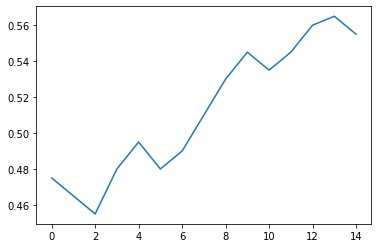

In [79]:
plt.plot(scores)